In [1]:
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import acquire as a
import prepare as p

import pandas as pd # to handle the dataframe
import numpy as np
from sklearn.model_selection import train_test_split


nltk.download('words')
words = set(nltk.corpus.words.words())

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package words to
[nltk_data]     /Users/cashamerica/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
df = a.get_data(query_url = False)
print(df.shape)
df = p.prepare_dataframe(df)
train, validate, test = p.split_data(df)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((53199, 63), (26599, 63), (26600, 63))

In [3]:
train.head()

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,...,hand_modifier,content_warning,flavor_name,usd,usd_foil,eur,eur_foil,is_foil,is_etched,is_glossy
12661,2d911053-a026-4b20-ba2d-dbcc367c1413,Ajani Goldmane,en,2010-07-16,normal,True,highres_scan,{2}{W}{W},4.0,Legendary Planeswalker — Ajani,...,0.0,False,no_flavor,8.02,15.11,3.50,9.48,True,False,False
61300,dcb2e0d6-3181-4d3d-a3b4-3896288b2e0e,Champion of Lambholt,en,2020-08-07,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Human Warrior,...,0.0,False,no_flavor,0.36,3.22,0.34,1.65,True,False,False
48604,af3aa149-00fa-4932-b004-f64c8b5d3ca7,Gargoyle,en,2009-07-17,token,True,highres_scan,,0.0,Token Artifact Creature — Gargoyle,...,0.0,False,no_flavor,0.25,0,0,0,False,False,False
55734,c8d75604-4941-4faf-8f1a-7fc529e64962,Goblin Settler,en,2022-04-12,normal,True,highres_scan,{3}{R},4.0,Creature — Goblin,...,0.0,False,no_flavor,9.76,11.87,0,0,True,False,False
70638,feef03a1-f19a-413b-ad86-0b357cf9c09c,Weight Advantage,en,2016-08-26,normal,True,highres_scan,,0.0,Conspiracy,...,0.0,False,no_flavor,0.11,0.42,0.04,0.90,True,False,False


In [14]:
train.set_type.value_counts().head(30)

expansion           16741
masters              6167
core                 5924
promo                5618
commander            4226
draft_innovation     3439
memorabilia          2420
box                  2329
duel_deck            1485
token                1213
starter               825
funny                 732
planechase            483
alchemy               407
treasure_chest        337
masterpiece           280
archenemy             258
from_the_vault        110
vanguard               84
premium_deck           80
arsenal                23
spellbook              18
Name: set_type, dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53199 entries, 12661 to 1677
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                53199 non-null  object        
 1   name              53199 non-null  object        
 2   lang              53199 non-null  object        
 3   released_at       53199 non-null  datetime64[ns]
 4   layout            53199 non-null  object        
 5   highres_image     53199 non-null  bool          
 6   image_status      53199 non-null  object        
 7   mana_cost         53199 non-null  object        
 8   cmc               53194 non-null  float64       
 9   type_line         53194 non-null  object        
 10  oracle_text       53199 non-null  object        
 11  power             53199 non-null  object        
 12  toughness         53199 non-null  object        
 13  colors            53199 non-null  object        
 14  color_identity    5

## Hypothesis 1

- H0: Artist mean USD and USD.foil price is = to the mean of the population 
- HA: Artist mean USD and USD.foil price is not = to the mean of the population 


In [5]:
train.rarity.value_counts()

common      19320
rare        17089
uncommon    13133
mythic       3471
special       177
bonus           9
Name: rarity, dtype: int64

In [44]:
train['usd'].value_counts()

0          12933
0.10        1611
0.09        1301
0.08        1173
0.05        1150
           ...  
28.61          1
1787.50        1
29.78          1
44.23          1
55.99          1
Name: usd, Length: 2895, dtype: int64

<AxesSubplot:>

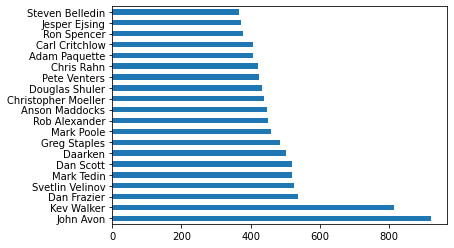

In [43]:
train['artist'].value_counts()[:20].plot(kind='barh')

<AxesSubplot:>

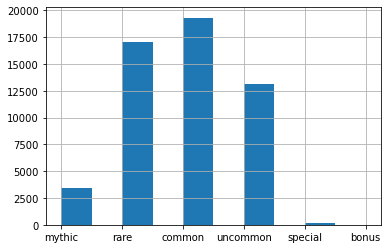

In [8]:
train.rarity.hist()

In [45]:
# filter out lands and tokens 

train = train.loc[train['rarity'].isin(['common', 'uncommon', 'rare', 
                                        'mythic', 'special', 'bonus'])]
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53199 entries, 12661 to 1677
Columns: 63 entries, id to is_glossy
dtypes: bool(17), datetime64[ns](1), float64(5), object(40)
memory usage: 19.9+ MB


This gives 53199 cards.

In [ ]:
train.info()

In [71]:
# show only data from the selected columns
df2 = train[['name', 'set_type', 'artist', 'rarity', 'usd', 'usd_foil']]


In [74]:
df2.sort_values(by=['set_type'], ascending=False,).head(40)

,name,set_type,artist,rarity,usd,usd_foil
26752,Mirror Entity Avatar,vanguard,UDON,rare,0,0
49892,Sisay,vanguard,Kaja Foglio,rare,10.59,0
56350,Flametongue Kavu Avatar,vanguard,UDON,rare,0,0
46749,Serra Angel Avatar,vanguard,UDON,rare,0,0
10126,"Rith, the Awakener Avatar",vanguard,UDON,rare,0,0
62430,Royal Assassin Avatar,vanguard,UDON,rare,0,0
59667,"Lyzolda, the Blood Witch Avatar",vanguard,UDON,rare,0,0
31601,Goblin Warchief Avatar,vanguard,UDON,rare,0,0
57031,Serra,vanguard,Matthew D. Wilson,rare,16.18,0
48662,Oracle,vanguard,Dan Frazier,rare,29.69,0


In [ ]:
sample = train[train.artist].rarity

sample.hist()

In [ ]:
train.plot(x='artist', y='artist', style='o')

## Hypothesis 2
- H0: artist and rarity of cards is = to price 
- HA: artist and rarity of cards is not = to price